<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

19:57:08 Starting...
19:57:08 Installing yfinance into Google notebook...
19:57:16 Installing arch into Google notebook...
19:57:25 Initialized.


## Get the Data

In [2]:
data,ticker_name=download(ticker:='SPY',end='2019-12-31',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month
1993-02-01,24.626421,24.626421,24.469897,24.469897,480500,0.711192,Monday,1,28,February
1993-02-02,24.678616,24.696007,24.556875,24.609049,201300,0.211946,Tuesday,2,28,February
1993-02-03,24.939478,24.956869,24.695996,24.713388,529400,1.057038,Wednesday,3,28,February
1993-02-04,25.043831,25.096006,24.748175,25.026439,531500,0.418425,Thursday,4,28,February
1993-02-05,25.026445,25.078620,24.887313,25.026445,492100,-0.069420,Friday,5,28,February
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917725,297.315186,296.769826,297.259727,52990000,0.152781,Monday,23,31,December
2019-12-24,296.926941,297.194980,296.621892,297.148774,20270000,0.003104,Tuesday,24,31,December
2019-12-26,298.507507,298.516760,297.305872,297.315096,30911200,0.532308,Thursday,26,31,December
2019-12-27,298.433624,299.302510,297.897517,299.247051,42528800,-0.024751,Friday,27,31,December


19:57:32 Wrote plot to Daily Returns of S&P 500 Index ETF.png.


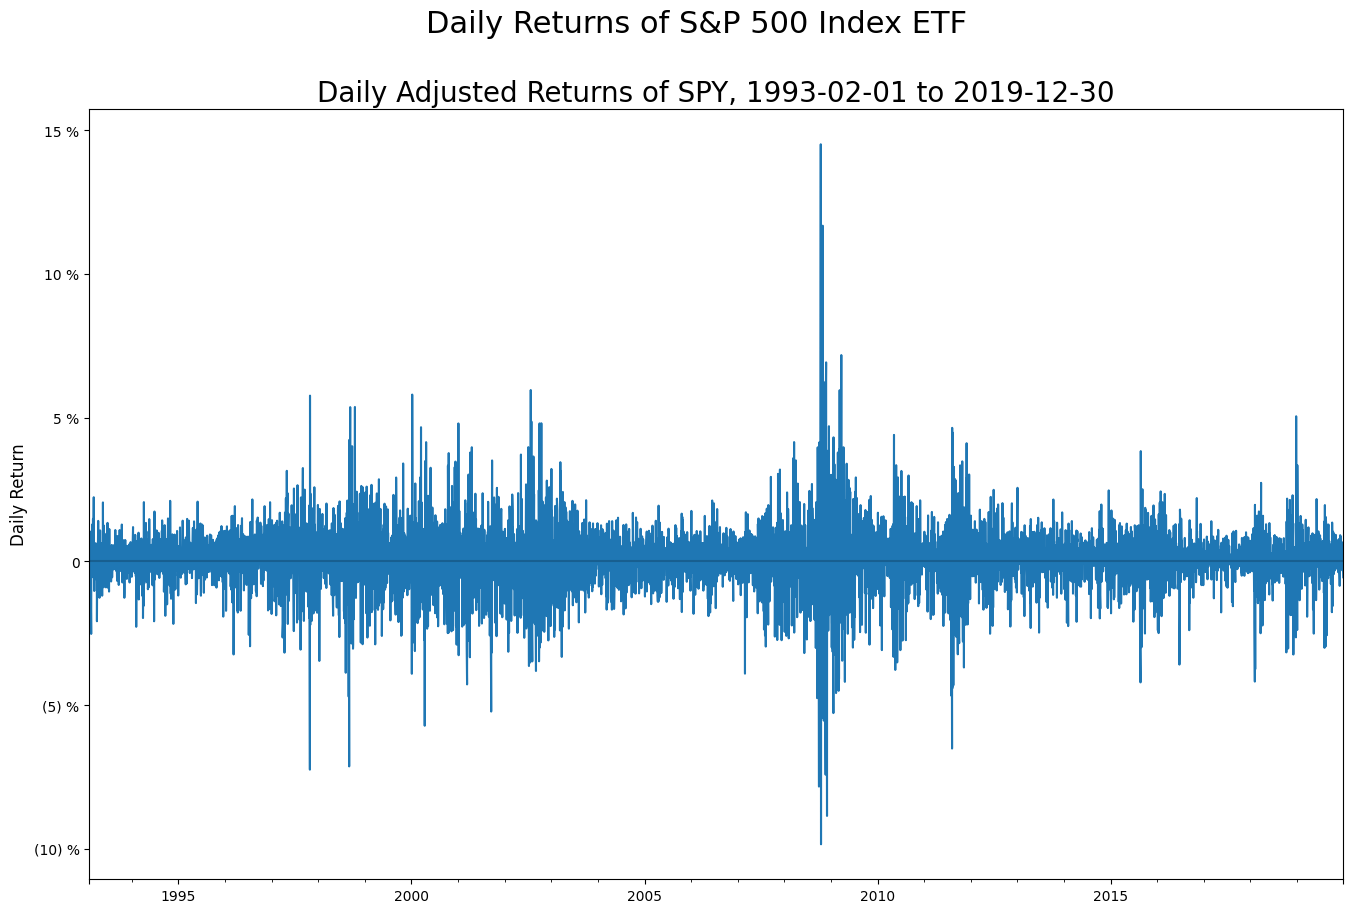

In [3]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
data['Return'].plot(ax=plot)
plot.set_ylabel("Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Daily Returns of {}".format(ticker_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
plot.axhline(color='black',alpha=0.2)
nprint("Wrote plot to {}.".format(filename))

## Analyse Returns by Day of the Week
### First Just a Simple Grouped Mean

19:59:49 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value
Day of Week,,,,,,
Monday,0.040138,1.264920,1277,0.035397,1.133923,0.257040
Tuesday,0.071446,1.159078,1389,0.031100,2.297305,0.021750
Wednesday,0.051835,1.095636,1390,0.029387,1.763847,0.077978
Thursday,0.023569,1.126047,1364,0.030489,0.773020,0.439645
Friday,0.028856,1.064545,1358,0.028888,0.998893,0.318025


19:59:50 Wrote plot to Average Returns of S&P 500 Index ETF by Day of Week.png.


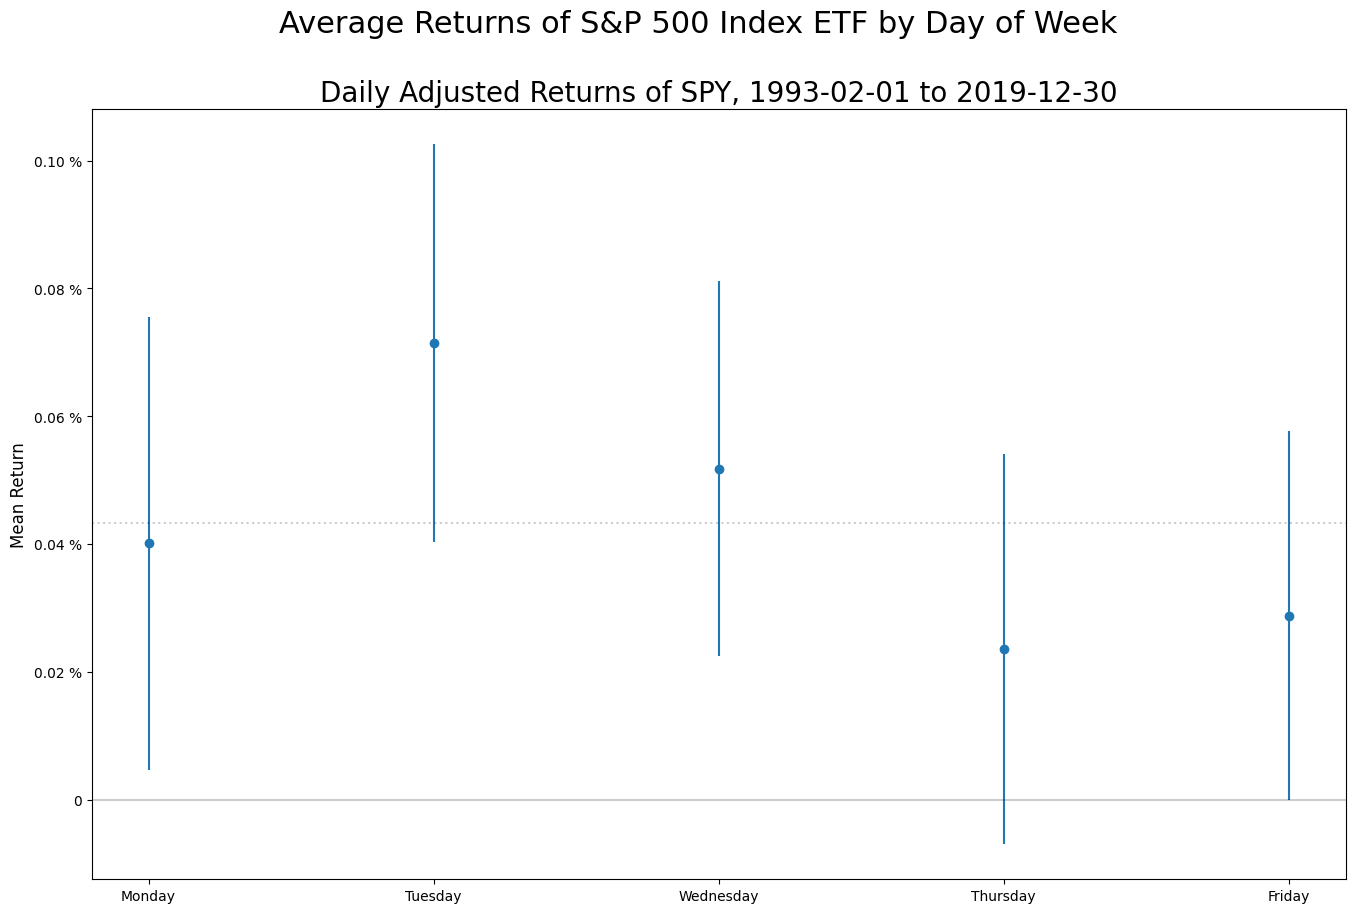

In [12]:
from scipy.stats import t as studentt

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Weekday']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results.index.name=(group_long_name:='Day of Week')
results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### One Way ANOVA Analysis

In [5]:
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("One Way ANOVA Analysis by {}".format(group_name))
anova=anova_lm(OLSformula("Return ~ {}".format(group_name),data).fit(),typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

19:57:37 One Way ANOVA Analysis by Weekday


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028737,4.0,0.3886,0.816954,
Within Groups,8839.822319,6773.0,,,


### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [6]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data[group_name],columns=[group_name],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

19:57:37 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711192
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211946
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057038
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418425
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069420
...,...,...,...,...,...,...
2019-12-23,1.0,0.0,0.0,0.0,0.0,0.152781
2019-12-24,0.0,1.0,0.0,0.0,0.0,0.003104
2019-12-26,0.0,0.0,0.0,1.0,0.0,0.532308
2019-12-27,0.0,0.0,0.0,0.0,1.0,-0.024751


19:57:37                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3886
Date:                Fri, 25 Apr 2025   Prob (F-statistic):              0.817
Time:                        19:57:37   Log-Likelihood:                -10518.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6773   BIC:                         2.108e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0401      0.032      1.255

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

In [7]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan,zero,zero,zero]+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
display(results.replace(np.nan,""))

19:57:37 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8763.592132467124
            Iterations: 18
            Function evaluations: 231
            Gradient evaluations: 18
19:57:39                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8763.59
Distribution:      Generalized Error Distribution   AIC:                           17547.2
Method:                        Maximum Likelihood   BIC:                           17615.4
                                                    No. Observations:                 6778
Date:                            Fri, Apr 25 2025   Df Residuals:                  

,Estimate,Std.Err.,Null Value,t Score,p Value,Significance
Monday,0.053278,0.019017,0.0,2.801668,0.005084,**
Tuesday,0.035977,0.021218,0.0,1.695589,0.089964,
Wednesday,0.075190,0.018049,0.0,4.165968,0.000031,***
Thursday,0.042089,0.019366,0.0,2.173385,0.029751,*
Friday,0.071241,0.020489,0.0,3.476951,0.000507,***
omega,0.017797,0.003186,,,,
alpha[1],-0.001303,0.006676,0.0,-0.195196,0.845239,
gamma[1],0.196251,0.023180,0.0,8.466279,0.0,***
beta[1],0.886568,0.012111,0.0,73.202214,0.0,***
nu,1.354816,0.037184,2.0,-17.351017,0.0,***


### Repeat the Simple Plot by Day of Week

19:57:43 Wrote plot to Estimated Daily Returns of S&P 500 Index ETF by Weekday.png.


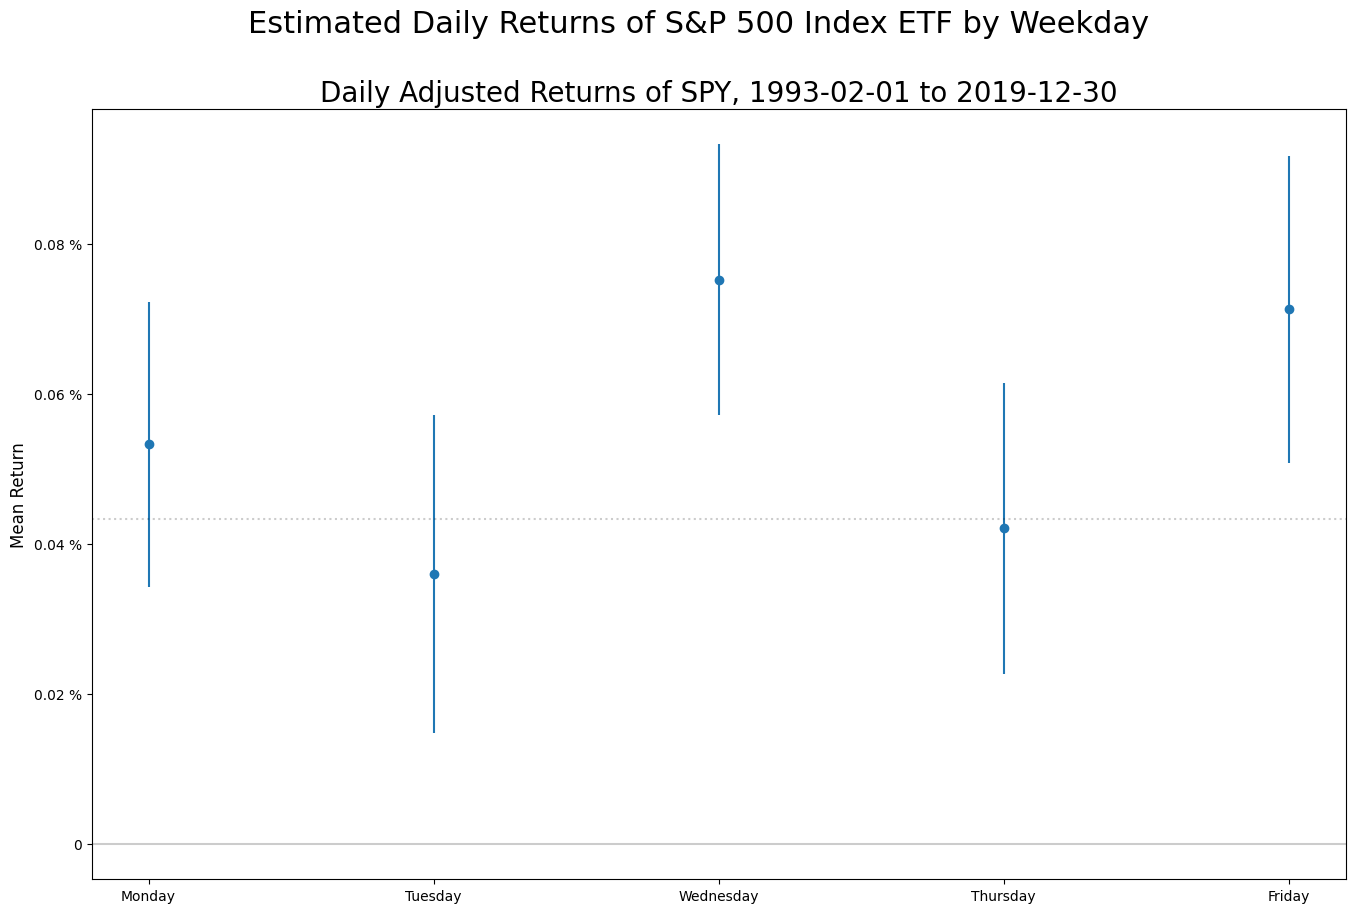

In [8]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x,results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
figure.suptitle(title:="Estimated Daily Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Compute the MLRT and AIC changes

In [9]:
from scipy.stats import chi2

aic=pd.DataFrame({
    'Model':['OLS','GJR-GARCH(1,1,1)'],
    'AIC':[ols_fit.aic,gjr_fit.aic],
    '-logL':[ols_fit.llf,gjr_fit.loglikelihood],
    'params':[ols_fit.params.shape[0]+1,gjr_fit.params.shape[0]]
}).set_index('Model')
aic.loc['Change']=aic.diff().iloc[-1]
aic.loc['Change','Chi.Sq.']=aic.loc['Change','-logL']*two
aic.loc['Change','p Value']=chi2.sf(aic.loc['Change','Chi.Sq.'],aic.loc['Change','params'])
display(aic.replace(np.nan,""))

,AIC,-logL,params,Chi.Sq.,p Value
Model,,,,,
OLS,21045.263877,-10517.631939,6.0,,
"GJR-GARCH(1,1,1)",17547.184265,-8763.592132,10.0,,
Change,-3498.079612,1754.039806,4.0,3508.079612,0.0


19:57:46 Wrote plot to Effect of Volatilty on Estimated Returns of S&P 500 Index ETF by Weekday.png.


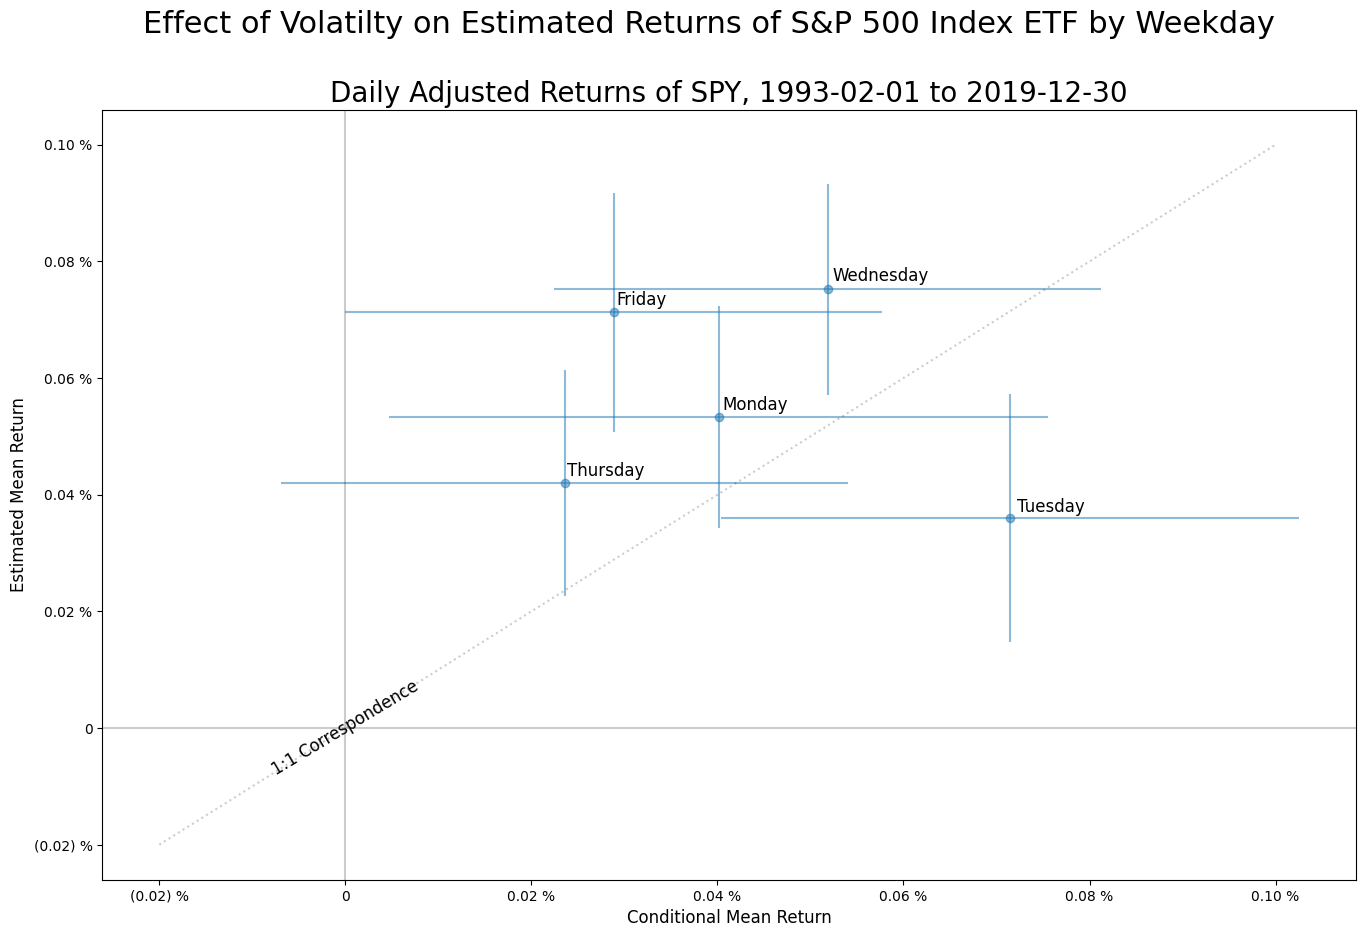

In [10]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(xx:=y,yy:=results.loc[x,'Estimate'],xerr=ye,yerr=results.loc[x,'Std.Err.'],fmt='o',alpha=0.5)

for day in x:
  plot.text(xx.loc[day]*1.01,yy.loc[day]*1.01,day,ha='left',va='bottom',fontsize=12)

plot.plot(r:=[min([-0.02,xx.min(),yy.min()]),max([0.1,xx.max(),yy.max()])],r,':',color='black',alpha=0.2)
plot.text(zero,zero,'1:1 Correspondence',fontsize=12,ha='center',va='center',rotation=31)
plot.axhline(color='black',alpha=0.2)
plot.axvline(color='black',alpha=0.2)
plot.set_xlabel("Conditional Mean Return",fontsize=12)
plot.set_ylabel("Estimated Mean Return",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(2))
plot.yaxis.set_major_formatter(PercentLabels(2))
figure.suptitle(title:="Effect of Volatilty on Estimated Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))